In [1]:
import gymnasium as gym
import highway_env
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from datetime import datetime
import os

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

In [2]:
env = gym.make("highway-v0", render_mode="rgb_array")
obs, info = env.reset()

print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Observation shape: {obs.shape}")
print(f"Observation dtype: {obs.dtype}")

print(f"Observation shape: {obs.shape}")
print(f"Min values: {np.min(obs, axis=(0,1))}")
print(f"Max values: {np.max(obs, axis=(0,1))}")
print(f"Mean values: {np.mean(obs, axis=(0,1))}")

Observation space: Box(-inf, inf, (5, 5), float32)
Action space: Discrete(5)
Observation shape: (5, 5)
Observation dtype: float32
Observation shape: (5, 5)
Min values: -0.042786940932273865
Max values: 1.0
Mean values: 0.3748089671134949


In [3]:
total_reward = 0
for step in range(10):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    
    print(f"Step {step+1}: Action={action}, Reward={reward:.3f}, "
            f"Terminated={terminated}, Truncated={truncated}")
    
    if terminated or truncated:
        print("Episode ended, resetting...")
        obs, info = env.reset()
        break

print(f"Total reward after random actions: {total_reward:.3f}")

Step 1: Action=2, Reward=0.821, Terminated=False, Truncated=False
Step 2: Action=4, Reward=0.712, Terminated=False, Truncated=False
Step 3: Action=0, Reward=0.669, Terminated=False, Truncated=False
Step 4: Action=3, Reward=0.778, Terminated=False, Truncated=False
Step 5: Action=1, Reward=0.796, Terminated=False, Truncated=False
Step 6: Action=4, Reward=0.689, Terminated=False, Truncated=False
Step 7: Action=4, Reward=0.670, Terminated=False, Truncated=False
Step 8: Action=1, Reward=0.667, Terminated=False, Truncated=False
Step 9: Action=4, Reward=0.667, Terminated=False, Truncated=False
Step 10: Action=1, Reward=0.667, Terminated=False, Truncated=False
Total reward after random actions: 7.135


In [4]:
config = env.unwrapped.config
pprint(dict(config))

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 4,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 50,
 'vehicles_density': 1}


In [5]:
frame = env.render()
print(f"Rendered frame shape: {frame.shape}")

Rendered frame shape: (150, 600, 3)


Saved rendered frame as 'highway_env_frame.png'


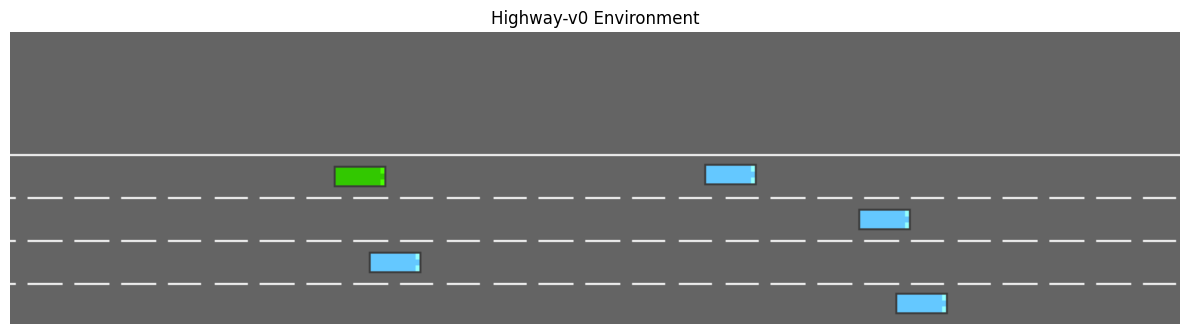

In [6]:
# Save the rendered frame
plt.figure(figsize=(12, 6))
plt.imshow(frame)
plt.title("Highway-v0 Environment")
plt.axis('off')
plt.tight_layout()
plt.savefig('highway_env_frame.png', dpi=150, bbox_inches='tight')
print("Saved rendered frame as 'highway_env_frame.png'")

env.close()

Merge environment observation space: Box(-inf, inf, (5, 5), float32)
Merge environment action space: Discrete(5)
Merge observation shape: (5, 5)
Saved merge environment frame as 'merge_env_frame.png'


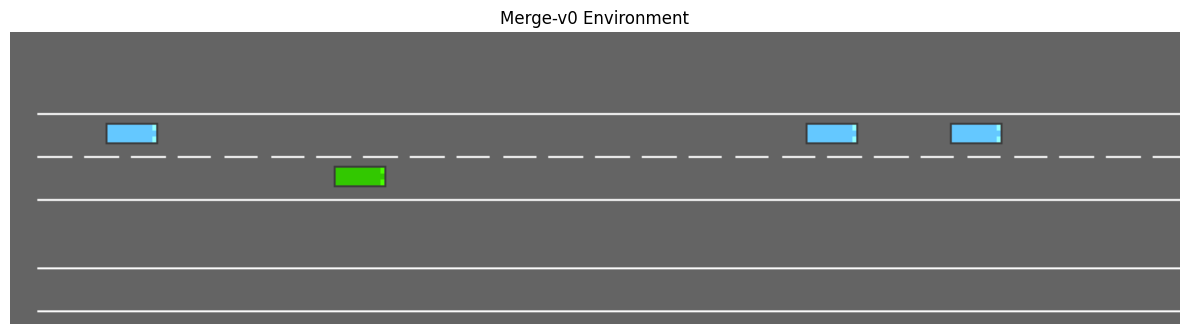

In [7]:
env = gym.make("merge-v0", render_mode="rgb_array")
obs, info = env.reset()

print(f"Merge environment observation space: {env.observation_space}")
print(f"Merge environment action space: {env.action_space}")
print(f"Merge observation shape: {obs.shape}")

# Render merge environment
frame = env.render()
plt.figure(figsize=(12, 6))
plt.imshow(frame)
plt.title("Merge-v0 Environment")
plt.axis('off')
plt.tight_layout()
plt.savefig('merge_env_frame.png', dpi=150, bbox_inches='tight')
print("Saved merge environment frame as 'merge_env_frame.png'")

env.close()

In [8]:
env = gym.make("highway-v0", render_mode="rgb_array")
    
config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "normalize": True
    },
    "lanes_count": 2,
    "vehicles_count": 10,
    "duration": 10,
    "collision_reward": -1,
    "reward_speed_range": [20, 30],
}

env.unwrapped.configure(config)

In [9]:
class QuickMetricsCallback(BaseCallback):
    """
    Simplified callback for quick training demo
    """
    def __init__(self, verbose=1):
        super(QuickMetricsCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_crashes = []
        
    def _on_step(self) -> bool:
        if len(self.locals.get('infos', [])) > 0:
            for info in self.locals['infos']:
                if 'episode' in info:
                    self.episode_rewards.append(info['episode']['r'])
                    self.episode_lengths.append(info['episode']['l'])
                    crashed = info.get('crashed', False)
                    self.episode_crashes.append(1 if crashed else 0)
                    if len(self.episode_rewards) % 100 == 0:
                        recent_reward = np.mean(self.episode_rewards[-2:])
                        recent_crashes = np.mean(self.episode_crashes[-2:]) * 100
                        print(f"Episode {len(self.episode_rewards):3d} | Reward: {recent_reward:6.2f} | Crash Rate: {recent_crashes:4.1f}%")
        return True

In [10]:
monitor_dir = f"./quick_monitor_{datetime.now().strftime('%H%M%S')}"
env = Monitor(env, monitor_dir)

model = PPO(
    "MlpPolicy",
    env,
    device="cpu",
    learning_rate=1e-3,
    n_steps=128,
    batch_size=16,
    n_epochs=2,
    gamma=0.98,
    gae_lambda=0.90,
    clip_range=0.2,
    ent_coef=0.01,
    verbose=1000,
    policy_kwargs=dict(net_arch=[32, 32])
)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [11]:
episode_rewards = []
episode_lengths = []
episode_crashes = []

In [12]:
callback = QuickMetricsCallback()
    
model.learn(total_timesteps=5000,callback=callback,progress_bar=True)

Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.63     |
|    ep_rew_mean     | 4.76     |
| time/              |          |
|    fps             | 35       |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 128      |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 6.56         |
|    ep_rew_mean          | 4.79         |
| time/                   |              |
|    fps                  | 30           |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.0015659896 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.61        |
|    explained_variance   | 0.019        |
|    learning_rate        | 0.001        |
|    loss                 | 1.58         |
|    n_updates            | 2            |
|    policy_gradient_loss | -0.0038      |
|    value_loss           | 4.86         |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 6.91          |
|    ep_rew_mean          | 5.06          |
| time/                   |               |
|    fps                  | 32            |
|    iterations           | 3             |
|    time_elapsed         | 11            |
|    total_timesteps      | 384           |
| train/                  |               |
|    approx_kl            | 0.00042209728 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.61         |
|    explained_variance   | 0.0521        |
|    learning_rate        | 0.001         |
|    loss                 | 1.38          |
|    n_updates            | 4             |
|    policy_gradient_loss | -0.00179      |
|    value_loss           | 3.82          |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.1          |
|    ep_rew_mean          | 5.19         |
| time/                   |              |
|    fps                  | 33           |
|    iterations           | 4            |
|    time_elapsed         | 15           |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 0.0017904956 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.6         |
|    explained_variance   | -0.0125      |
|    learning_rate        | 0.001        |
|    loss                 | 1.82         |
|    n_updates            | 6            |
|    policy_gradient_loss | -0.00769     |
|    value_loss           | 4.59         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.18         |
|    ep_rew_mean          | 5.26         |
| time/                   |              |
|    fps                  | 33           |
|    iterations           | 5            |
|    time_elapsed         | 18           |
|    total_timesteps      | 640          |
| train/                  |              |
|    approx_kl            | 0.0065409155 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.58        |
|    explained_variance   | -0.0136      |
|    learning_rate        | 0.001        |
|    loss                 | 2.63         |
|    n_updates            | 8            |
|    policy_gradient_loss | -0.00631     |
|    value_loss           | 5.23         |
------------------------------------------


Episode 100 | Reward:   7.01 | Crash Rate: 50.0%

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.4         |
|    ep_rew_mean          | 5.41        |
| time/                   |             |
|    fps                  | 34          |
|    iterations           | 6           |
|    time_elapsed         | 22          |
|    total_timesteps      | 768         |
| train/                  |             |
|    approx_kl            | 0.006494027 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | -0.0151     |
|    learning_rate        | 0.001       |
|    loss                 | 4.11        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0146     |
|    value_loss           | 6.17        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.83         |
|    ep_rew_mean          | 5.77         |
| time/                   |              |
|    fps                  | 34           |
|    iterations           | 7            |
|    time_elapsed         | 25           |
|    total_timesteps      | 896          |
| train/                  |              |
|    approx_kl            | 0.0031153942 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.49        |
|    explained_variance   | -0.012       |
|    learning_rate        | 0.001        |
|    loss                 | 3.12         |
|    n_updates            | 12           |
|    policy_gradient_loss | -0.00282     |
|    value_loss           | 6.55         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.24       |
|    ep_rew_mean          | 6.06       |
| time/                   |            |
|    fps                  | 35         |
|    iterations           | 8          |
|    time_elapsed         | 28         |
|    total_timesteps      | 1024       |
| train/                  |            |
|    approx_kl            | 0.00151644 |
|    clip_fraction        | 0          |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.46      |
|    explained_variance   | 0.00127    |
|    learning_rate        | 0.001      |
|    loss                 | 3.78       |
|    n_updates            | 14         |
|    policy_gradient_loss | -0.00186   |
|    value_loss           | 7.01       |
----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 8.6           |
|    ep_rew_mean          | 6.37          |
| time/                   |               |
|    fps                  | 35            |
|    iterations           | 9             |
|    time_elapsed         | 32            |
|    total_timesteps      | 1152          |
| train/                  |               |
|    approx_kl            | 0.00086065335 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.43         |
|    explained_variance   | 0.0132        |
|    learning_rate        | 0.001         |
|    loss                 | 1.85          |
|    n_updates            | 16            |
|    policy_gradient_loss | -0.00324      |
|    value_loss           | 7.07          |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 8.62         |
|    ep_rew_mean          | 6.36         |
| time/                   |              |
|    fps                  | 36           |
|    iterations           | 10           |
|    time_elapsed         | 35           |
|    total_timesteps      | 1280         |
| train/                  |              |
|    approx_kl            | 0.0022040834 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | -0.0122      |
|    learning_rate        | 0.001        |
|    loss                 | 2.78         |
|    n_updates            | 18           |
|    policy_gradient_loss | -0.00441     |
|    value_loss           | 7.21         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 8.77         |
|    ep_rew_mean          | 6.45         |
| time/                   |              |
|    fps                  | 35           |
|    iterations           | 11           |
|    time_elapsed         | 39           |
|    total_timesteps      | 1408         |
| train/                  |              |
|    approx_kl            | 0.0106831975 |
|    clip_fraction        | 0.0938       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 0.00224      |
|    learning_rate        | 0.001        |
|    loss                 | 5.16         |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.0126      |
|    value_loss           | 8.94         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.07       |
|    ep_rew_mean          | 6.62       |
| time/                   |            |
|    fps                  | 36         |
|    iterations           | 12         |
|    time_elapsed         | 42         |
|    total_timesteps      | 1536       |
| train/                  |            |
|    approx_kl            | 0.01080345 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.18      |
|    explained_variance   | 0.00758    |
|    learning_rate        | 0.001      |
|    loss                 | 2.67       |
|    n_updates            | 22         |
|    policy_gradient_loss | -0.00967   |
|    value_loss           | 8.41       |
----------------------------------------


Episode 200 | Reward:   5.43 | Crash Rate: 50.0%

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.03        |
|    ep_rew_mean          | 6.53        |
| time/                   |             |
|    fps                  | 36          |
|    iterations           | 13          |
|    time_elapsed         | 45          |
|    total_timesteps      | 1664        |
| train/                  |             |
|    approx_kl            | 0.010755096 |
|    clip_fraction        | 0.0781      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.01       |
|    explained_variance   | -0.00382    |
|    learning_rate        | 0.001       |
|    loss                 | 4.93        |
|    n_updates            | 24          |
|    policy_gradient_loss | -0.00831    |
|    value_loss           | 10.2        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.16         |
|    ep_rew_mean          | 6.59         |
| time/                   |              |
|    fps                  | 36           |
|    iterations           | 14           |
|    time_elapsed         | 49           |
|    total_timesteps      | 1792         |
| train/                  |              |
|    approx_kl            | 0.0014851531 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.887       |
|    explained_variance   | 0.0029       |
|    learning_rate        | 0.001        |
|    loss                 | 2.86         |
|    n_updates            | 26           |
|    policy_gradient_loss | -0.00349     |
|    value_loss           | 7.98         |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.18          |
|    ep_rew_mean          | 6.57          |
| time/                   |               |
|    fps                  | 36            |
|    iterations           | 15            |
|    time_elapsed         | 52            |
|    total_timesteps      | 1920          |
| train/                  |               |
|    approx_kl            | 0.00040820753 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.822        |
|    explained_variance   | 0.00407       |
|    learning_rate        | 0.001         |
|    loss                 | 1.7           |
|    n_updates            | 28            |
|    policy_gradient_loss | 0.000739      |
|    value_loss           | 5.58          |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.27          |
|    ep_rew_mean          | 6.58          |
| time/                   |               |
|    fps                  | 36            |
|    iterations           | 16            |
|    time_elapsed         | 56            |
|    total_timesteps      | 2048          |
| train/                  |               |
|    approx_kl            | 0.00082034664 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.797        |
|    explained_variance   | 0.00493       |
|    learning_rate        | 0.001         |
|    loss                 | 3.96          |
|    n_updates            | 30            |
|    policy_gradient_loss | -0.00162      |
|    value_loss           | 6.48          |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.36         |
|    ep_rew_mean          | 6.62         |
| time/                   |              |
|    fps                  | 36           |
|    iterations           | 17           |
|    time_elapsed         | 59           |
|    total_timesteps      | 2176         |
| train/                  |              |
|    approx_kl            | 0.0009554215 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.739       |
|    explained_variance   | 0.00867      |
|    learning_rate        | 0.001        |
|    loss                 | 0.82         |
|    n_updates            | 32           |
|    policy_gradient_loss | -0.0029      |
|    value_loss           | 5.52         |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.5           |
|    ep_rew_mean          | 6.69          |
| time/                   |               |
|    fps                  | 36            |
|    iterations           | 18            |
|    time_elapsed         | 62            |
|    total_timesteps      | 2304          |
| train/                  |               |
|    approx_kl            | 0.00035320362 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.71         |
|    explained_variance   | 0.00905       |
|    learning_rate        | 0.001         |
|    loss                 | 1.44          |
|    n_updates            | 34            |
|    policy_gradient_loss | -0.000234     |
|    value_loss           | 5.91          |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.63         |
|    ep_rew_mean          | 6.81         |
| time/                   |              |
|    fps                  | 36           |
|    iterations           | 19           |
|    time_elapsed         | 65           |
|    total_timesteps      | 2432         |
| train/                  |              |
|    approx_kl            | 3.385218e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.699       |
|    explained_variance   | 0.0183       |
|    learning_rate        | 0.001        |
|    loss                 | 1.23         |
|    n_updates            | 36           |
|    policy_gradient_loss | -0.000217    |
|    value_loss           | 3.33         |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.67          |
|    ep_rew_mean          | 6.85          |
| time/                   |               |
|    fps                  | 37            |
|    iterations           | 20            |
|    time_elapsed         | 68            |
|    total_timesteps      | 2560          |
| train/                  |               |
|    approx_kl            | 7.0864335e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.686        |
|    explained_variance   | 0.0139        |
|    learning_rate        | 0.001         |
|    loss                 | 1.14          |
|    n_updates            | 38            |
|    policy_gradient_loss | -3.98e-05     |
|    value_loss           | 3.34          |
-------------------------------------------


Episode 300 | Reward:   7.03 | Crash Rate: 50.0%

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.77         |
|    ep_rew_mean          | 6.95         |
| time/                   |              |
|    fps                  | 37           |
|    iterations           | 21           |
|    time_elapsed         | 71           |
|    total_timesteps      | 2688         |
| train/                  |              |
|    approx_kl            | 6.381096e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.694       |
|    explained_variance   | 0.000297     |
|    learning_rate        | 0.001        |
|    loss                 | 1.52         |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.000253    |
|    value_loss           | 6.16         |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.78          |
|    ep_rew_mean          | 6.95          |
| time/                   |               |
|    fps                  | 38            |
|    iterations           | 22            |
|    time_elapsed         | 73            |
|    total_timesteps      | 2816          |
| train/                  |               |
|    approx_kl            | 0.00066628726 |
|    clip_fraction        | 0.00391       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.644        |
|    explained_variance   | -0.000181     |
|    learning_rate        | 0.001         |
|    loss                 | 5.45          |
|    n_updates            | 42            |
|    policy_gradient_loss | -0.000823     |
|    value_loss           | 10.3          |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.87          |
|    ep_rew_mean          | 7.01          |
| time/                   |               |
|    fps                  | 38            |
|    iterations           | 23            |
|    time_elapsed         | 76            |
|    total_timesteps      | 2944          |
| train/                  |               |
|    approx_kl            | 0.00040589552 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.652        |
|    explained_variance   | -0.000638     |
|    learning_rate        | 0.001         |
|    loss                 | 8.95          |
|    n_updates            | 44            |
|    policy_gradient_loss | -0.000393     |
|    value_loss           | 6.89          |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.82         |
|    ep_rew_mean          | 6.97         |
| time/                   |              |
|    fps                  | 39           |
|    iterations           | 24           |
|    time_elapsed         | 78           |
|    total_timesteps      | 3072         |
| train/                  |              |
|    approx_kl            | 0.0014235456 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.627       |
|    explained_variance   | 0.00352      |
|    learning_rate        | 0.001        |
|    loss                 | 1.18         |
|    n_updates            | 46           |
|    policy_gradient_loss | -0.00492     |
|    value_loss           | 7.04         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.84         |
|    ep_rew_mean          | 6.98         |
| time/                   |              |
|    fps                  | 39           |
|    iterations           | 25           |
|    time_elapsed         | 81           |
|    total_timesteps      | 3200         |
| train/                  |              |
|    approx_kl            | 0.0002667457 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.564       |
|    explained_variance   | 0.00211      |
|    learning_rate        | 0.001        |
|    loss                 | 0.803        |
|    n_updates            | 48           |
|    policy_gradient_loss | -0.00121     |
|    value_loss           | 6.75         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.81         |
|    ep_rew_mean          | 6.94         |
| time/                   |              |
|    fps                  | 39           |
|    iterations           | 26           |
|    time_elapsed         | 83           |
|    total_timesteps      | 3328         |
| train/                  |              |
|    approx_kl            | 0.0019617663 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.585       |
|    explained_variance   | 0.0141       |
|    learning_rate        | 0.001        |
|    loss                 | 0.995        |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.000751    |
|    value_loss           | 2.45         |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.81          |
|    ep_rew_mean          | 6.93          |
| time/                   |               |
|    fps                  | 40            |
|    iterations           | 27            |
|    time_elapsed         | 86            |
|    total_timesteps      | 3456          |
| train/                  |               |
|    approx_kl            | 0.00040144566 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.599        |
|    explained_variance   | 0.000387      |
|    learning_rate        | 0.001         |
|    loss                 | 4.35          |
|    n_updates            | 52            |
|    policy_gradient_loss | -0.00199      |
|    value_loss           | 7.79          |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.84         |
|    ep_rew_mean          | 6.95         |
| time/                   |              |
|    fps                  | 40           |
|    iterations           | 28           |
|    time_elapsed         | 88           |
|    total_timesteps      | 3584         |
| train/                  |              |
|    approx_kl            | 0.0028909175 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.506       |
|    explained_variance   | 0.00666      |
|    learning_rate        | 0.001        |
|    loss                 | 1.02         |
|    n_updates            | 54           |
|    policy_gradient_loss | 0.00154      |
|    value_loss           | 2.2          |
------------------------------------------


Episode 400 | Reward:   7.43 | Crash Rate:  0.0%

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.87          |
|    ep_rew_mean          | 7.01          |
| time/                   |               |
|    fps                  | 40            |
|    iterations           | 29            |
|    time_elapsed         | 91            |
|    total_timesteps      | 3712          |
| train/                  |               |
|    approx_kl            | 7.3765405e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.478        |
|    explained_variance   | 0.00716       |
|    learning_rate        | 0.001         |
|    loss                 | 0.805         |
|    n_updates            | 56            |
|    policy_gradient_loss | 0.000293      |
|    value_loss           | 2             |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.85          |
|    ep_rew_mean          | 6.96          |
| time/                   |               |
|    fps                  | 40            |
|    iterations           | 30            |
|    time_elapsed         | 94            |
|    total_timesteps      | 3840          |
| train/                  |               |
|    approx_kl            | 0.00023943372 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.486        |
|    explained_variance   | 0.00485       |
|    learning_rate        | 0.001         |
|    loss                 | 0.552         |
|    n_updates            | 58            |
|    policy_gradient_loss | -0.000998     |
|    value_loss           | 2.15          |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.82         |
|    ep_rew_mean          | 6.94         |
| time/                   |              |
|    fps                  | 40           |
|    iterations           | 31           |
|    time_elapsed         | 96           |
|    total_timesteps      | 3968         |
| train/                  |              |
|    approx_kl            | 0.0035053245 |
|    clip_fraction        | 0.043        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.56        |
|    explained_variance   | 0.00193      |
|    learning_rate        | 0.001        |
|    loss                 | 3.31         |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00848     |
|    value_loss           | 8.84         |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.87          |
|    ep_rew_mean          | 6.97          |
| time/                   |               |
|    fps                  | 41            |
|    iterations           | 32            |
|    time_elapsed         | 99            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00040151225 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.61         |
|    explained_variance   | 0.000889      |
|    learning_rate        | 0.001         |
|    loss                 | 5.88          |
|    n_updates            | 62            |
|    policy_gradient_loss | -0.000444     |
|    value_loss           | 8.14          |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.86         |
|    ep_rew_mean          | 6.95         |
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 33           |
|    time_elapsed         | 101          |
|    total_timesteps      | 4224         |
| train/                  |              |
|    approx_kl            | 0.0005064015 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.622       |
|    explained_variance   | 0.0128       |
|    learning_rate        | 0.001        |
|    loss                 | 0.559        |
|    n_updates            | 64           |
|    policy_gradient_loss | -0.00091     |
|    value_loss           | 1.65         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.86        |
|    ep_rew_mean          | 6.97        |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 34          |
|    time_elapsed         | 104         |
|    total_timesteps      | 4352        |
| train/                  |             |
|    approx_kl            | 0.001462304 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.643      |
|    explained_variance   | -0.000502   |
|    learning_rate        | 0.001       |
|    loss                 | 23.2        |
|    n_updates            | 66          |
|    policy_gradient_loss | -0.000265   |
|    value_loss           | 19.1        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.86        |
|    ep_rew_mean          | 6.96        |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 35          |
|    time_elapsed         | 106         |
|    total_timesteps      | 4480        |
| train/                  |             |
|    approx_kl            | 0.002433756 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.673      |
|    explained_variance   | 0.00813     |
|    learning_rate        | 0.001       |
|    loss                 | 0.776       |
|    n_updates            | 68          |
|    policy_gradient_loss | -0.0106     |
|    value_loss           | 1.85        |
-----------------------------------------


Episode 500 | Reward:   7.59 | Crash Rate:  0.0%

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.86        |
|    ep_rew_mean          | 6.94        |
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 36          |
|    time_elapsed         | 109         |
|    total_timesteps      | 4608        |
| train/                  |             |
|    approx_kl            | 0.008195901 |
|    clip_fraction        | 0.0938      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.761      |
|    explained_variance   | 0.00043     |
|    learning_rate        | 0.001       |
|    loss                 | 14          |
|    n_updates            | 70          |
|    policy_gradient_loss | 0.00315     |
|    value_loss           | 11.7        |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.86          |
|    ep_rew_mean          | 6.95          |
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 37            |
|    time_elapsed         | 111           |
|    total_timesteps      | 4736          |
| train/                  |               |
|    approx_kl            | 0.00028052414 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.806        |
|    explained_variance   | 0.00131       |
|    learning_rate        | 0.001         |
|    loss                 | 5.37          |
|    n_updates            | 72            |
|    policy_gradient_loss | -0.000837     |
|    value_loss           | 11.9          |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.96        |
|    ep_rew_mean          | 7.03        |
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 38          |
|    time_elapsed         | 114         |
|    total_timesteps      | 4864        |
| train/                  |             |
|    approx_kl            | 0.002953818 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.843      |
|    explained_variance   | 0.00574     |
|    learning_rate        | 0.001       |
|    loss                 | 0.691       |
|    n_updates            | 74          |
|    policy_gradient_loss | 0.00614     |
|    value_loss           | 1.61        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.96        |
|    ep_rew_mean          | 7.03        |
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 39          |
|    time_elapsed         | 116         |
|    total_timesteps      | 4992        |
| train/                  |             |
|    approx_kl            | 0.004063875 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.839      |
|    explained_variance   | 0.00855     |
|    learning_rate        | 0.001       |
|    loss                 | 0.317       |
|    n_updates            | 76          |
|    policy_gradient_loss | -0.0111     |
|    value_loss           | 1.17        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10           |
|    ep_rew_mean          | 7.05         |
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 40           |
|    time_elapsed         | 119          |
|    total_timesteps      | 5120         |
| train/                  |              |
|    approx_kl            | 0.0033929362 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.773       |
|    explained_variance   | 0.0111       |
|    learning_rate        | 0.001        |
|    loss                 | 0.26         |
|    n_updates            | 78           |
|    policy_gradient_loss | 0.00173      |
|    value_loss           | 1.08         |
------------------------------------------


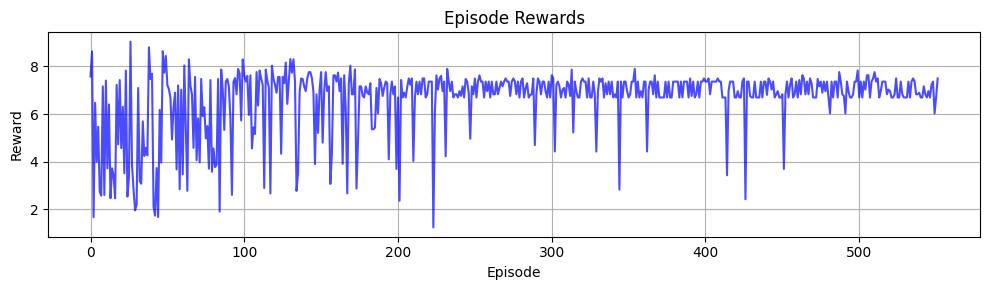

In [13]:
plt.figure(figsize=(10, 3))
plt.plot(callback.episode_rewards, 'b-', alpha=0.7)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(f"TRAINING SUMMARY")
print(f"Episodes completed: {len(callback.episode_rewards)}")
print(f"Mean reward: {np.mean(callback.episode_rewards):.2f}")
print(f"Final reward (last 2): {np.mean(callback.episode_rewards[-2:]):.2f}")
print(f"Crash rate: {np.mean(callback.episode_crashes)*100:.1f}%")
print(f"Mean episode length: {np.mean(callback.episode_lengths):.1f}")


📈 TRAINING SUMMARY
   Episodes completed: 552
   Mean reward: 6.61
   Final reward (last 2): 7.09
   Crash rate: 21.9%
   Mean episode length: 9.3


In [15]:
env = gym.make("highway-v0", render_mode="rgb_array")
    
config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "normalize": True
    },
    "lanes_count": 3,
    "vehicles_count": 30,
    "duration": 10,
    "collision_reward": -1,
    "reward_speed_range": [20, 30],
}

env.unwrapped.configure(config)

In [16]:
episode_rewards = []
episode_lengths = []
episode_crashes = []

In [17]:
callback = QuickMetricsCallback()
    
model.learn(total_timesteps=5000,callback=callback,progress_bar=True)

Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 7.12     |
| time/              |          |
|    fps             | 51       |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 128      |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.88        |
|    ep_rew_mean          | 7.02        |
| time/                   |             |
|    fps                  | 50          |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 256         |
| train/                  |             |
|    approx_kl            | 0.006912674 |
|    clip_fraction        | 0.0508      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.842      |
|    explained_variance   | 0.00839     |
|    learning_rate        | 0.001       |
|    loss                 | 0.337       |
|    n_updates            | 82          |
|    policy_gradient_loss | -0.00749    |
|    value_loss           | 1.24        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.82        |
|    ep_rew_mean          | 7.04        |
| time/                   |             |
|    fps                  | 49          |
|    iterations           | 3           |
|    time_elapsed         | 7           |
|    total_timesteps      | 384         |
| train/                  |             |
|    approx_kl            | 0.011232356 |
|    clip_fraction        | 0.0938      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.902      |
|    explained_variance   | 0.000458    |
|    learning_rate        | 0.001       |
|    loss                 | 3.72        |
|    n_updates            | 84          |
|    policy_gradient_loss | -0.00276    |
|    value_loss           | 13.6        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.71      |
|    ep_rew_mean          | 6.95      |
| time/                   |           |
|    fps                  | 49        |
|    iterations           | 4         |
|    time_elapsed         | 10        |
|    total_timesteps      | 512       |
| train/                  |           |
|    approx_kl            | 0.0198443 |
|    clip_fraction        | 0.184     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.922    |
|    explained_variance   | -0.000605 |
|    learning_rate        | 0.001     |
|    loss                 | 0.622     |
|    n_updates            | 86        |
|    policy_gradient_loss | -0.013    |
|    value_loss           | 12.9      |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.68         |
|    ep_rew_mean          | 6.89         |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 5            |
|    time_elapsed         | 12           |
|    total_timesteps      | 640          |
| train/                  |              |
|    approx_kl            | 0.0008092439 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.885       |
|    explained_variance   | -0.000509    |
|    learning_rate        | 0.001        |
|    loss                 | 21.4         |
|    n_updates            | 88           |
|    policy_gradient_loss | -0.00154     |
|    value_loss           | 24.1         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.66         |
|    ep_rew_mean          | 6.89         |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 6            |
|    time_elapsed         | 15           |
|    total_timesteps      | 768          |
| train/                  |              |
|    approx_kl            | 0.0028753048 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.914       |
|    explained_variance   | 0.000196     |
|    learning_rate        | 0.001        |
|    loss                 | 14.8         |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.0052      |
|    value_loss           | 40.1         |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.64          |
|    ep_rew_mean          | 6.87          |
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 7             |
|    time_elapsed         | 18            |
|    total_timesteps      | 896           |
| train/                  |               |
|    approx_kl            | 0.00065794867 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.9          |
|    explained_variance   | 0.00107       |
|    learning_rate        | 0.001         |
|    loss                 | 18            |
|    n_updates            | 92            |
|    policy_gradient_loss | 0.00077       |
|    value_loss           | 24.6          |
-------------------------------------------


Episode 100 | Reward:   6.69 | Crash Rate:  0.0%

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.67       |
|    ep_rew_mean          | 6.88       |
| time/                   |            |
|    fps                  | 49         |
|    iterations           | 8          |
|    time_elapsed         | 20         |
|    total_timesteps      | 1024       |
| train/                  |            |
|    approx_kl            | 0.01379696 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.851     |
|    explained_variance   | -0.000326  |
|    learning_rate        | 0.001      |
|    loss                 | 0.525      |
|    n_updates            | 94         |
|    policy_gradient_loss | -0.00568   |
|    value_loss           | 10.9       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.66         |
|    ep_rew_mean          | 6.88         |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 9            |
|    time_elapsed         | 23           |
|    total_timesteps      | 1152         |
| train/                  |              |
|    approx_kl            | 0.0004455913 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.854       |
|    explained_variance   | 0.0159       |
|    learning_rate        | 0.001        |
|    loss                 | 0.316        |
|    n_updates            | 96           |
|    policy_gradient_loss | -0.00141     |
|    value_loss           | 1.07         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.65        |
|    ep_rew_mean          | 6.87        |
| time/                   |             |
|    fps                  | 49          |
|    iterations           | 10          |
|    time_elapsed         | 25          |
|    total_timesteps      | 1280        |
| train/                  |             |
|    approx_kl            | 0.006648139 |
|    clip_fraction        | 0.0273      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.905      |
|    explained_variance   | -0.00032    |
|    learning_rate        | 0.001       |
|    loss                 | 0.517       |
|    n_updates            | 98          |
|    policy_gradient_loss | -0.0073     |
|    value_loss           | 14.7        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.64         |
|    ep_rew_mean          | 6.85         |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 11           |
|    time_elapsed         | 28           |
|    total_timesteps      | 1408         |
| train/                  |              |
|    approx_kl            | 0.0003601038 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.939       |
|    explained_variance   | 0.000407     |
|    learning_rate        | 0.001        |
|    loss                 | 19.4         |
|    n_updates            | 100          |
|    policy_gradient_loss | 0.00177      |
|    value_loss           | 39.3         |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.67          |
|    ep_rew_mean          | 6.86          |
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 12            |
|    time_elapsed         | 31            |
|    total_timesteps      | 1536          |
| train/                  |               |
|    approx_kl            | 0.00045930827 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.906        |
|    explained_variance   | 0.00105       |
|    learning_rate        | 0.001         |
|    loss                 | 0.839         |
|    n_updates            | 102           |
|    policy_gradient_loss | 0.00131       |
|    value_loss           | 14.4          |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.61         |
|    ep_rew_mean          | 6.81         |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 13           |
|    time_elapsed         | 33           |
|    total_timesteps      | 1664         |
| train/                  |              |
|    approx_kl            | 0.0003693346 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.926       |
|    explained_variance   | -0.000515    |
|    learning_rate        | 0.001        |
|    loss                 | 19           |
|    n_updates            | 104          |
|    policy_gradient_loss | -0.00128     |
|    value_loss           | 38.5         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.72         |
|    ep_rew_mean          | 6.89         |
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 14           |
|    time_elapsed         | 36           |
|    total_timesteps      | 1792         |
| train/                  |              |
|    approx_kl            | 0.0014877999 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.894       |
|    explained_variance   | 0.000646     |
|    learning_rate        | 0.001        |
|    loss                 | 38           |
|    n_updates            | 106          |
|    policy_gradient_loss | -0.00395     |
|    value_loss           | 37           |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.7         |
|    ep_rew_mean          | 6.86        |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 15          |
|    time_elapsed         | 39          |
|    total_timesteps      | 1920        |
| train/                  |             |
|    approx_kl            | 0.001947376 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.861      |
|    explained_variance   | 0.00197     |
|    learning_rate        | 0.001       |
|    loss                 | 0.776       |
|    n_updates            | 108         |
|    policy_gradient_loss | -0.00378    |
|    value_loss           | 14.2        |
-----------------------------------------


Episode 200 | Reward:   7.42 | Crash Rate:  0.0%

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.7         |
|    ep_rew_mean          | 6.87        |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 16          |
|    time_elapsed         | 41          |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.018040223 |
|    clip_fraction        | 0.0938      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.744      |
|    explained_variance   | 0.0012      |
|    learning_rate        | 0.001       |
|    loss                 | 4.95        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00166    |
|    value_loss           | 13.6        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.71         |
|    ep_rew_mean          | 6.87         |
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 17           |
|    time_elapsed         | 44           |
|    total_timesteps      | 2176         |
| train/                  |              |
|    approx_kl            | 0.0022086021 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.612       |
|    explained_variance   | 0.0124       |
|    learning_rate        | 0.001        |
|    loss                 | 0.294        |
|    n_updates            | 112          |
|    policy_gradient_loss | -0.00464     |
|    value_loss           | 1.2          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.75         |
|    ep_rew_mean          | 6.86         |
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 18           |
|    time_elapsed         | 47           |
|    total_timesteps      | 2304         |
| train/                  |              |
|    approx_kl            | 0.0012138002 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.559       |
|    explained_variance   | 0.0181       |
|    learning_rate        | 0.001        |
|    loss                 | 0.187        |
|    n_updates            | 114          |
|    policy_gradient_loss | -0.00432     |
|    value_loss           | 0.921        |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.82         |
|    ep_rew_mean          | 6.91         |
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 19           |
|    time_elapsed         | 50           |
|    total_timesteps      | 2432         |
| train/                  |              |
|    approx_kl            | 0.0026069288 |
|    clip_fraction        | 0.0195       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.5         |
|    explained_variance   | 0.00145      |
|    learning_rate        | 0.001        |
|    loss                 | 9.44         |
|    n_updates            | 116          |
|    policy_gradient_loss | -0.00657     |
|    value_loss           | 13.7         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.84         |
|    ep_rew_mean          | 6.95         |
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 20           |
|    time_elapsed         | 52           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0007870896 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.414       |
|    explained_variance   | 0.00238      |
|    learning_rate        | 0.001        |
|    loss                 | 0.697        |
|    n_updates            | 118          |
|    policy_gradient_loss | 0.000291     |
|    value_loss           | 15.9         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.92         |
|    ep_rew_mean          | 6.99         |
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 21           |
|    time_elapsed         | 55           |
|    total_timesteps      | 2688         |
| train/                  |              |
|    approx_kl            | 7.278286e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.388       |
|    explained_variance   | 0.0257       |
|    learning_rate        | 0.001        |
|    loss                 | 0.331        |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.000103    |
|    value_loss           | 0.991        |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.93          |
|    ep_rew_mean          | 7             |
| time/                   |               |
|    fps                  | 48            |
|    iterations           | 22            |
|    time_elapsed         | 57            |
|    total_timesteps      | 2816          |
| train/                  |               |
|    approx_kl            | 0.00015395368 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.415        |
|    explained_variance   | 0.0321        |
|    learning_rate        | 0.001         |
|    loss                 | 0.166         |
|    n_updates            | 122           |
|    policy_gradient_loss | 0.000253      |
|    value_loss           | 0.687         |
-------------------------------------------


Episode 300 | Reward:   6.89 | Crash Rate:  0.0%

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95         |
|    ep_rew_mean          | 7.01         |
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 23           |
|    time_elapsed         | 60           |
|    total_timesteps      | 2944         |
| train/                  |              |
|    approx_kl            | 0.0007228181 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.405       |
|    explained_variance   | 0.0327       |
|    learning_rate        | 0.001        |
|    loss                 | 0.191        |
|    n_updates            | 124          |
|    policy_gradient_loss | -0.00236     |
|    value_loss           | 0.618        |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95         |
|    ep_rew_mean          | 7.01         |
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 24           |
|    time_elapsed         | 63           |
|    total_timesteps      | 3072         |
| train/                  |              |
|    approx_kl            | 0.0005899044 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.366       |
|    explained_variance   | 0.0298       |
|    learning_rate        | 0.001        |
|    loss                 | 0.118        |
|    n_updates            | 126          |
|    policy_gradient_loss | -0.00227     |
|    value_loss           | 0.506        |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.94          |
|    ep_rew_mean          | 7.01          |
| time/                   |               |
|    fps                  | 48            |
|    iterations           | 25            |
|    time_elapsed         | 66            |
|    total_timesteps      | 3200          |
| train/                  |               |
|    approx_kl            | 2.3816712e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.329        |
|    explained_variance   | 0.014         |
|    learning_rate        | 0.001         |
|    loss                 | 0.128         |
|    n_updates            | 128           |
|    policy_gradient_loss | 0.000246      |
|    value_loss           | 0.593         |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.98         |
|    ep_rew_mean          | 7.03         |
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 26           |
|    time_elapsed         | 69           |
|    total_timesteps      | 3328         |
| train/                  |              |
|    approx_kl            | 0.0009277384 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.379       |
|    explained_variance   | 0.00097      |
|    learning_rate        | 0.001        |
|    loss                 | 20           |
|    n_updates            | 130          |
|    policy_gradient_loss | 0.00347      |
|    value_loss           | 19.6         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.97         |
|    ep_rew_mean          | 6.99         |
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 27           |
|    time_elapsed         | 72           |
|    total_timesteps      | 3456         |
| train/                  |              |
|    approx_kl            | 0.0001957058 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.426       |
|    explained_variance   | 0.026        |
|    learning_rate        | 0.001        |
|    loss                 | 0.146        |
|    n_updates            | 132          |
|    policy_gradient_loss | 0.000804     |
|    value_loss           | 0.54         |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.97          |
|    ep_rew_mean          | 6.97          |
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 28            |
|    time_elapsed         | 77            |
|    total_timesteps      | 3584          |
| train/                  |               |
|    approx_kl            | 0.00055741286 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.426        |
|    explained_variance   | -0.000532     |
|    learning_rate        | 0.001         |
|    loss                 | 29.3          |
|    n_updates            | 134           |
|    policy_gradient_loss | -0.00199      |
|    value_loss           | 38.7          |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.92          |
|    ep_rew_mean          | 6.92          |
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 29            |
|    time_elapsed         | 80            |
|    total_timesteps      | 3712          |
| train/                  |               |
|    approx_kl            | 0.00076046586 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.367        |
|    explained_variance   | 0.00139       |
|    learning_rate        | 0.001         |
|    loss                 | 12.1          |
|    n_updates            | 136           |
|    policy_gradient_loss | -0.000495     |
|    value_loss           | 20.3          |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.92         |
|    ep_rew_mean          | 6.92         |
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 30           |
|    time_elapsed         | 83           |
|    total_timesteps      | 3840         |
| train/                  |              |
|    approx_kl            | 5.617831e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.342       |
|    explained_variance   | -0.00092     |
|    learning_rate        | 0.001        |
|    loss                 | 0.442        |
|    n_updates            | 138          |
|    policy_gradient_loss | -0.000826    |
|    value_loss           | 16.1         |
------------------------------------------


Episode 400 | Reward:   7.03 | Crash Rate:  0.0%

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.92         |
|    ep_rew_mean          | 6.94         |
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 31           |
|    time_elapsed         | 86           |
|    total_timesteps      | 3968         |
| train/                  |              |
|    approx_kl            | 3.088033e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.342       |
|    explained_variance   | 0.0349       |
|    learning_rate        | 0.001        |
|    loss                 | 0.124        |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.000525    |
|    value_loss           | 0.553        |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.91          |
|    ep_rew_mean          | 6.89          |
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 32            |
|    time_elapsed         | 89            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00010974659 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.332        |
|    explained_variance   | 0.0187        |
|    learning_rate        | 0.001         |
|    loss                 | 0.127         |
|    n_updates            | 142           |
|    policy_gradient_loss | -0.000451     |
|    value_loss           | 0.468         |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.92          |
|    ep_rew_mean          | 6.91          |
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 33            |
|    time_elapsed         | 96            |
|    total_timesteps      | 4224          |
| train/                  |               |
|    approx_kl            | 5.1417388e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.392        |
|    explained_variance   | 0.000919      |
|    learning_rate        | 0.001         |
|    loss                 | 7.45          |
|    n_updates            | 144           |
|    policy_gradient_loss | 0.00155       |
|    value_loss           | 20.8          |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.92        |
|    ep_rew_mean          | 6.93        |
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 34          |
|    time_elapsed         | 102         |
|    total_timesteps      | 4352        |
| train/                  |             |
|    approx_kl            | 0.000689792 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.361      |
|    explained_variance   | 0.0204      |
|    learning_rate        | 0.001       |
|    loss                 | 0.175       |
|    n_updates            | 146         |
|    policy_gradient_loss | -0.000145   |
|    value_loss           | 0.551       |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.94          |
|    ep_rew_mean          | 6.99          |
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 35            |
|    time_elapsed         | 105           |
|    total_timesteps      | 4480          |
| train/                  |               |
|    approx_kl            | 0.00016628811 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.323        |
|    explained_variance   | 0.0193        |
|    learning_rate        | 0.001         |
|    loss                 | 0.1           |
|    n_updates            | 148           |
|    policy_gradient_loss | -0.00128      |
|    value_loss           | 0.394         |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.94        |
|    ep_rew_mean          | 7.02        |
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 36          |
|    time_elapsed         | 108         |
|    total_timesteps      | 4608        |
| train/                  |             |
|    approx_kl            | 8.51932e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.301      |
|    explained_variance   | -0.00012    |
|    learning_rate        | 0.001       |
|    loss                 | 20.6        |
|    n_updates            | 150         |
|    policy_gradient_loss | -6.42e-06   |
|    value_loss           | 22.4        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.99         |
|    ep_rew_mean          | 7.06         |
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 37           |
|    time_elapsed         | 111          |
|    total_timesteps      | 4736         |
| train/                  |              |
|    approx_kl            | 2.228422e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.335       |
|    explained_variance   | 0.0272       |
|    learning_rate        | 0.001        |
|    loss                 | 0.139        |
|    n_updates            | 152          |
|    policy_gradient_loss | 0.000575     |
|    value_loss           | 0.455        |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.99          |
|    ep_rew_mean          | 7.06          |
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 38            |
|    time_elapsed         | 114           |
|    total_timesteps      | 4864          |
| train/                  |               |
|    approx_kl            | 0.00024924288 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.32         |
|    explained_variance   | 0.0231        |
|    learning_rate        | 0.001         |
|    loss                 | 0.0681        |
|    n_updates            | 154           |
|    policy_gradient_loss | -0.000114     |
|    value_loss           | 0.258         |
-------------------------------------------


Episode 500 | Reward:   7.09 | Crash Rate:  0.0%

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.98          |
|    ep_rew_mean          | 7.05          |
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 39            |
|    time_elapsed         | 117           |
|    total_timesteps      | 4992          |
| train/                  |               |
|    approx_kl            | 0.00049116276 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.308        |
|    explained_variance   | 0.0262        |
|    learning_rate        | 0.001         |
|    loss                 | 0.0171        |
|    n_updates            | 156           |
|    policy_gradient_loss | -0.00207      |
|    value_loss           | 0.21          |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.99         |
|    ep_rew_mean          | 7.06         |
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 40           |
|    time_elapsed         | 120          |
|    total_timesteps      | 5120         |
| train/                  |              |
|    approx_kl            | 0.0040250006 |
|    clip_fraction        | 0.0469       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.232       |
|    explained_variance   | 0.000495     |
|    learning_rate        | 0.001        |
|    loss                 | 0.133        |
|    n_updates            | 158          |
|    policy_gradient_loss | 0.000633     |
|    value_loss           | 24.7         |
------------------------------------------


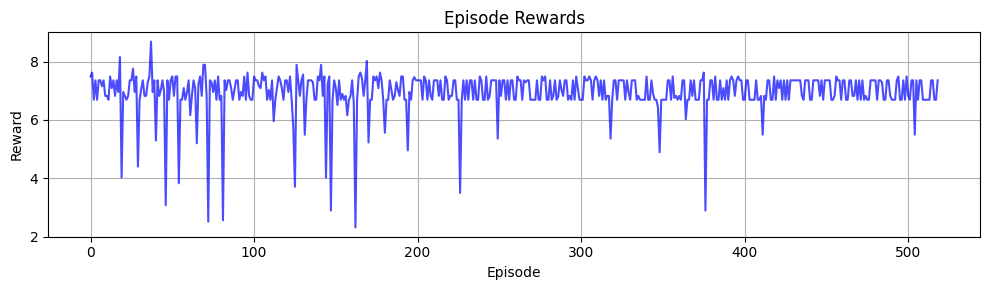

In [18]:
plt.figure(figsize=(10, 3))
plt.plot(callback.episode_rewards, 'b-', alpha=0.7)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
print(f"TRAINING SUMMARY")
print(f"Episodes completed: {len(callback.episode_rewards)}")
print(f"Mean reward: {np.mean(callback.episode_rewards):.2f}")
print(f"Final reward (last 2): {np.mean(callback.episode_rewards[-2:]):.2f}")
print(f"Crash rate: {np.mean(callback.episode_crashes)*100:.1f}%")
print(f"Mean episode length: {np.mean(callback.episode_lengths):.1f}")

TRAINING SUMMARY
Episodes completed: 519
Mean reward: 6.95
Final reward (last 2): 7.03
Crash rate: 6.4%
Mean episode length: 9.8
